# Flipkart Product reviews with sentiment Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import shutil
shutil.copy2("/content/drive/MyDrive/Colab Notebooks/kaggle.json", "/content/")

'/content/kaggle.json'

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download niraliivaghani/flipkart-product-customer-reviews-dataset

  0% 0.00/3.79M [00:00<?, ?B/s]
100% 3.79M/3.79M [00:00<00:00, 205MB/s]


In [7]:
# extracting the data
from zipfile import ZipFile
with ZipFile("/content/flipkart-product-customer-reviews-dataset.zip", "r") as zipref:
  zipref.extractall("/content/flipkart-product-customer-reviews-dataset")

## Getting the data and preprocessing it

In [8]:
data_path = "/content/flipkart-product-customer-reviews-dataset/Dataset-SA.csv"

In [9]:
df = pd.read_csv(data_path)
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [10]:
# the sentiment (output) was given based on a column called Summary
# so the other columns are not useful
upd_df = df.drop(["product_name", "product_price", "Rate", "Review"], axis=1)
upd_df.head()

,Summary,Sentiment
0,great cooler excellent air flow and for this p...,positive
1,best budget 2 fit cooler nice cooling,positive
2,the quality is good but the power of air is de...,positive
3,very bad product its a only a fan,negative
4,ok ok product,neutral


In [11]:
len(upd_df)

205052

In [12]:
upd_df.isna().sum()

Summary      11
Sentiment     0
dtype: int64

In [13]:
upd_df.dropna(inplace=True)

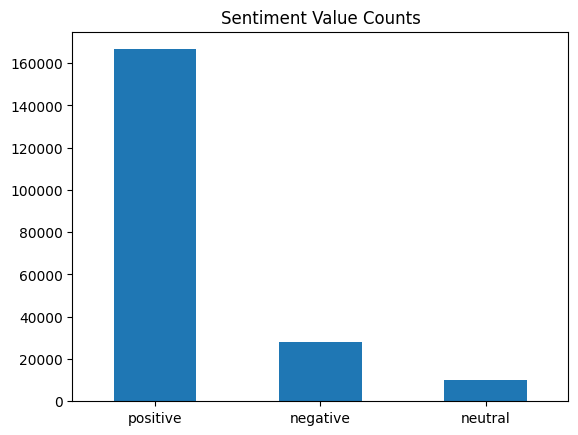

In [14]:
upd_df["Sentiment"].value_counts().plot.bar()
plt.title("Sentiment Value Counts")
plt.xticks(rotation=0);

In [15]:
upd_df.head()

,Summary,Sentiment
0,great cooler excellent air flow and for this p...,positive
1,best budget 2 fit cooler nice cooling,positive
2,the quality is good but the power of air is de...,positive
3,very bad product its a only a fan,negative
4,ok ok product,neutral


In [16]:
X = np.array(upd_df["Summary"].to_list())
y = np.array(upd_df["Sentiment"].to_list())

In [17]:
# encoding the Sentiment values
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)
y

array([2, 2, 2, ..., 2, 2, 1])

In [18]:
upd_df["Sentiment"].value_counts()

positive    166575
negative     28232
neutral      10234
Name: Sentiment, dtype: int64

In [19]:
pd.DataFrame(y).value_counts()
# 2 - positive
# 0 - negative
# 1 - neutral

2    166575
0     28232
1     10234
dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
len(X_train), len(X_test)

(143528, 61513)

## Model 1: MultinomialNB

In [21]:
# creating a training pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

model_1 = Pipeline(steps=[
    ["Encoder", TfidfVectorizer()],
    ["NB", MultinomialNB()]
])

model_1.fit(X_train, y_train)
model_1.score(X_test, y_test)

0.8730837383967617

In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# creating a results dataframe
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1_score"])
i = 0

def calculate_metrics(y_true, y_pred, model_name):
  """
  Calculates Accuracy, Precision, Recall, F1-Score
  """
  acc = accuracy_score(y_true, y_pred)
  pre, rec, fs, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  global i
  
  results_df.loc[i] = [model_name, acc, pre, rec, fs]
  i+=1

  print("Added to results_df")

In [23]:
# metrics for model_1
pred = model_1.predict(X_test)
calculate_metrics(y_test, pred, "MultinomialNB")

Added to results_df


In [24]:
results_df

,Model,Accuracy,Precision,Recall,F1_score
0,MultinomialNB,0.873084,0.877355,0.873084,0.842714


## Model 2: Gated Recurrent Unit

In [25]:
X[0]

'great cooler excellent air flow and for this price its so amazing and unbelievablejust love it'

In [26]:
len(X[0].split())

16

In [27]:
# finding median text length
length = [len(text.split()) for text in X]
length[:5]

[16, 7, 11, 8, 3]

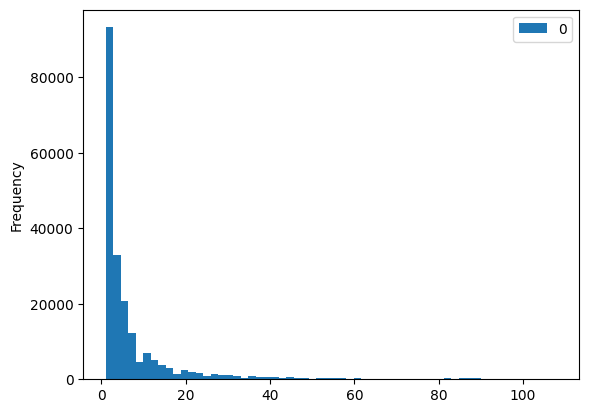

In [28]:
pd.DataFrame(length).plot.hist(bins=60);

In [29]:
max_token = max(length)
avg_length = round(np.mean(length))
max_token, avg_length

(108, 8)

In [30]:
import tensorflow as tf

# creating a text vectorization layer
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=max_token, output_sequence_length=avg_length)
text_vectorization.adapt(X_train)

In [31]:
X_test[0]

'best'

In [32]:
# making a sample pass
text_vectorization(X_test[0])

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([21,  0,  0,  0,  0,  0,  0,  0])>

In [33]:
# creating an embedding layer
embedding = tf.keras.layers.Embedding(input_dim=max_token, output_dim=avg_length)
embedding

In [34]:
embedding(text_vectorization(X_test[0]))

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[ 0.01431968,  0.01532048, -0.04851766, -0.02632025, -0.03412715,
        -0.00209139,  0.02858848,  0.04628377],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172,  0.00268887],
       [-0.0259002 , -0.01652706, -0.04131113, -0.01123565, -0.01118196,
         0.03855332, -0.01538172

In [35]:
text_vectorization(X_test[0]).shape

TensorShape([8])

In [36]:
embedding(text_vectorization(X_test[0])).shape

TensorShape([8, 8])

In [37]:
# setting random seed
tf.random.set_seed = 42

# creating a GRU model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),

    text_vectorization,
    embedding,

    tf.keras.layers.GRU(16),

    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),

    tf.keras.layers.Dense(3, activation="softmax")
])

model_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

model_2_history = model_2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_split=int(len(X_test)*0.3), batch_size=64)

Epoch 1/5
2243/2243 [==============================] - 54s 15ms/step - loss: 0.3148 - accuracy: 0.8915 - val_loss: 0.2570 - val_accuracy: 0.9058
Epoch 2/5
2243/2243 [==============================] - 25s 11ms/step - loss: 0.2508 - accuracy: 0.9081 - val_loss: 0.2480 - val_accuracy: 0.9101
Epoch 3/5
2243/2243 [==============================] - 26s 12ms/step - loss: 0.2432 - accuracy: 0.9118 - val_loss: 0.2415 - val_accuracy: 0.9128
Epoch 4/5
2243/2243 [==============================] - 25s 11ms/step - loss: 0.2386 - accuracy: 0.9131 - val_loss: 0.2412 - val_accuracy: 0.9124
Epoch 5/5
2243/2243 [==============================] - 25s 11ms/step - loss: 0.2361 - accuracy: 0.9139 - val_loss: 0.2360 - val_accuracy: 0.9134


In [38]:
pred = tf.argmax(model_2.predict(X_test), axis=1)
calculate_metrics(y_test, pred, "GRU")

1923/1923 [==============================] - 8s 4ms/step
Added to results_df


In [39]:
results_df

,Model,Accuracy,Precision,Recall,F1_score
0,MultinomialNB,0.873084,0.877355,0.873084,0.842714
1,GRU,0.913449,0.907678,0.913449,0.902286


## Model 3: With USE

In [68]:
import tensorflow_hub as hub

# seting random seed
tf.random.set_seed = 42

use = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False
)

In [69]:
use([X_train[0]]).shape

TensorShape([1, 512])

In [70]:
# seting random seed
tf.random.set_seed = 42

inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

x = use(inputs)

x = tf.keras.layers.GRU(16)(tf.expand_dims(x, axis=1))
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)

output = tf.keras.layers.Dense(3, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, output)

model_3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

model_3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_split=int(len(X_test)*0.3), batch_size=64)

Epoch 1/5
2243/2243 [==============================] - 112s 45ms/step - loss: 0.2225 - accuracy: 0.9241 - val_loss: 0.1927 - val_accuracy: 0.9345
Epoch 2/5
2243/2243 [==============================] - 78s 35ms/step - loss: 0.1867 - accuracy: 0.9358 - val_loss: 0.1903 - val_accuracy: 0.9348
Epoch 3/5
2243/2243 [==============================] - 105s 47ms/step - loss: 0.1815 - accuracy: 0.9364 - val_loss: 0.1843 - val_accuracy: 0.9363
Epoch 4/5
2243/2243 [==============================] - 77s 34ms/step - loss: 0.1776 - accuracy: 0.9378 - val_loss: 0.1819 - val_accuracy: 0.9368
Epoch 5/5
2243/2243 [==============================] - 102s 46ms/step - loss: 0.1742 - accuracy: 0.9385 - val_loss: 0.1802 - val_accuracy: 0.9370


In [71]:
pred = tf.argmax(model_3.predict([X_test]), axis=1)
calculate_metrics(y_test, pred, "GRU with USE")

1923/1923 [==============================] - 25s 12ms/step
Added to results_df


In [72]:
results_df

,Model,Accuracy,Precision,Recall,F1_score
0,MultinomialNB,0.873084,0.877355,0.873084,0.842714
1,GRU,0.913449,0.907678,0.913449,0.902286
2,GRU with USE,0.937021,0.933523,0.937021,0.932076


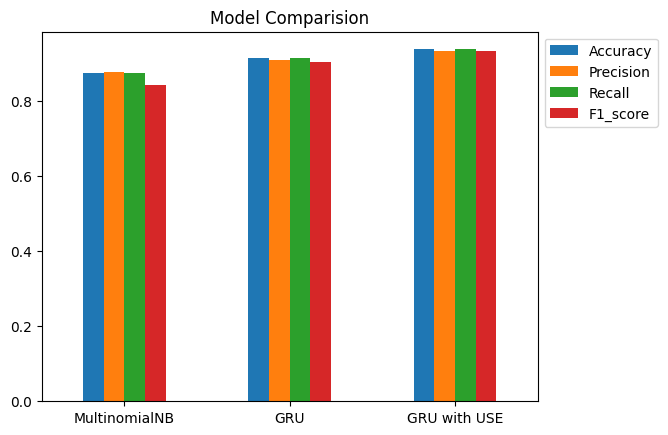

In [76]:
results_df.plot.bar()
plt.title("Model Comparision")
plt.xticks(range(3), labels=results_df["Model"], rotation=0)
plt.legend(bbox_to_anchor=(1.0, 1.0));

## Saving the Best performing model

In [77]:
# saving model 3
model_3.save("/content/Model_3_GRU_with_USE.h5")

In [78]:
shutil.copy2("/content/Model_3_GRU_with_USE.h5", "/content/drive/MyDrive/Colab Notebooks/")

'/content/drive/MyDrive/Colab Notebooks/Model_3_GRU_with_USE.h5'

In [86]:
# loading the model
final_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Model_3_GRU_with_USE.h5",
                                          custom_objects={'KerasLayer':hub.KerasLayer})

In [124]:
# class names
# 2 - positive
# 0 - negative
# 1 - neutral
class_names = ["negative", "neutral", "positive"]

# making custom predictions
def make_pred(X):

  X = tf.expand_dims(X, axis=0)
  pred = final_model.predict(X)

  pred_label = class_names[tf.argmax(pred, axis=1)[0]]

  return f"Prediction: {pred_label}"

In [137]:
list(y_test).index(1)
# finding the index of neutral

14

In [138]:
print(make_pred(X_test[14]))

1/1 [==============================] - 0s 40ms/step
Prediction: neutral


In [139]:
class_names[y_test[14]]

'neutral'